# CAT-DOG IMAGE CLASSIFIER

<p><b>Status: <span style=color:orange;>In progress</span></b></p>

##### LOCATE FILE NAMES

In [1]:
import pandas as pd
import numpy as np
import pickle
import os

data_dir = '../../../data/'
classes = os.listdir(data_dir)  # get classes from folder names

# load feature data
filename = '../../02-data-preprocessing/output/preprocessed_data/X.pckl'
loader = open(filename, 'rb')
X = pickle.load(loader)
loader.close()

# load target data
filename = '../../02-data-preprocessing/output/preprocessed_data/y.pckl'
loader = open(filename, 'rb')
y = pickle.load(loader)
loader.close()

In [2]:
import pandas as pd

y = pd.get_dummies(y)
y.head()

,Cat,Dog
0,1,0
1,0,1
2,0,1
3,0,1
4,1,0


##### SPLIT THE FILE NAMES INTO TRAINING AND TESTING SETS

In [3]:
from sklearn.model_selection import train_test_split

# set the seed for reproducibility
np.random.seed(127)

X = X[:500]
y = y[:500]

# split the dataset into 2 training and 2 testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=13)

# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

print('Data shapes:\n')
print('X_train : {}\ny_train : {}\n\nX_test : {}\ny_test : {}'.format(np.shape(X_train),
                                                                      np.shape(y_train),
                                                                      np.shape(X_test),
                                                                      np.shape(y_test)))

Data shapes:

X_train : (240, 64, 64, 3)
y_train : (240, 2)

X_test : (60, 64, 64, 3)
y_test : (60, 2)


##### DEFINE NETWORK PARAMETERS

In [4]:
#extract images properties
image_width  = np.shape(X_test)[1]
image_height = np.shape(X_test)[2]
n_channel  = np.shape(X_test)[3]
n_classes = np.shape(y_train)[1]

# count number of samples in each set of data
n_train = np.shape(X_train)[0]
n_test = np.shape(X_test)[0]

# define amount of neurons
#n_layer_in = n_features  # 11 neurons in input layer
n_layer_h1 = 50          # first   hidden layer
n_layer_h2 = 50          # second  hidden layer
n_layer_out = n_classes  # 7 neurons in input layer

sigma_init = 0.01   # For randomized initialization

##### MODEL ARCHITECTURE

In [5]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Activation

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024))
model.add(Dense(n_classes))
model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
__________

In [6]:
# initiate RMSprop optimizer
opt = tensorflow.keras.optimizers.RMSprop(lr=0.001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Train on 240 samples, validate on 60 samples
Epoch 1/50
240/240 [==============================] - 38s 158ms/step - loss: 1.7221 - acc: 0.5146 - val_loss: 0.7180 - val_acc: 0.4667
Epoch 2/50
240/240 [==============================] - 21s 87ms/step - loss: 0.6963 - acc: 0.5312 - val_loss: 0.6963 - val_acc: 0.4667
Epoch 3/50
240/240 [==============================] - 20s 84ms/step - loss: 0.7025 - acc: 0.5583 - val_loss: 0.6927 - val_acc: 0.5333
Epoch 4/50
240/240 [==============================] - 20s 84ms/step - loss: 0.6753 - acc: 0.5958 - val_loss: 0.7311 - val_acc: 0.5333
Epoch 5/50
240/240 [==============================] - 19s 80ms/step - loss: 0.6912 - acc: 0.5854 - val_loss: 0.6837 - val_acc: 0.5333
Epoch 6/50
240/240 [==============================] - 19s 81ms/step - loss: 0.6557 - acc: 0.6292 - val_loss: 0.7218 - val_acc: 0.5167
Epoch 7/50
240/240 [==============================] - 19s 80ms/step - loss: 0.6191 - acc: 0.6333 - val_loss: 0.7563 - val_acc: 0.5333
Epoch 8/50
240/2

##### VISUALIZE THE RESULTS

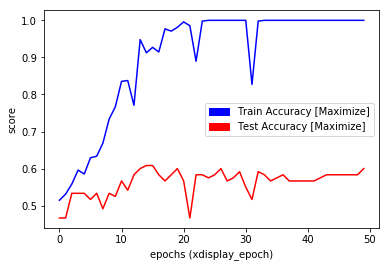

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# set up legend
blue_patch = mpatches.Patch(color='blue', label='Train Accuracy [Maximize]')
red_patch = mpatches.Patch(color='red', label='Test Accuracy [Maximize]')
plt.legend(handles=[blue_patch,red_patch])

#plot the data
plt.plot(history.history['acc'], color='blue')
plt.plot(history.history['val_acc'], color='red')

plt.xlabel('epochs (x{})'.format('display_epoch'))
plt.ylabel('score');